In [1]:
import os, glob, csv, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.metrics import r2_score, explained_variance_score

In [2]:
def make_pred_df():
    
    normal_files = glob.glob(r'../results/eye-movement-prediction/preds_normal/*.tsv')
    permuted_files = glob.glob(r'../results/eye-movement-prediction/preds_permuted/*.tsv')
    scrambled_files = glob.glob(r'../results/eye-movement-prediction/preds_scrambled/*.tsv')
    
    # Read in files as dataframes + add column with filenames
    normal_dfs = []
    for file in normal_files:
        df = pd.read_csv(file, sep='\t', names=['et_metric', 'pred', 'true'])
        df['pred'] = [float(pred.lstrip('[').rstrip(']')) for pred in df['pred'].tolist()]
        df['true'] = [float(true.lstrip('[').rstrip(']')) for true in df['true'].tolist()]
        df['fold'] = len(df) * [file[-5]]
        df['input_type'] = len(df) * ['normal']
        df['language'] = len(df) * [file[:-6].lstrip('../results/eye-movement-prediction/preds_normal\preds_eval-meco-')]
        normal_dfs.append(df)
    normal_preds = pd.concat(normal_dfs, axis=0, ignore_index=True)

    permuted_dfs = []
    for file in permuted_files:
        df = pd.read_csv(file, sep='\t', names=['et_metric', 'pred', 'true'])
        df['pred'] = [float(pred.lstrip('[').rstrip(']')) for pred in df['pred'].tolist()]
        df['true'] = [float(true.lstrip('[').rstrip(']')) for true in df['true'].tolist()]
        df['fold'] = len(df) * [file[-5]]
        df['input_type'] = len(df) * ['permuted']
        df['language'] = len(df) * [file[:-6].lstrip('../results/eye-movement-prediction/preds_permuted\preds_eval-meco-permuted-')]
        permuted_dfs.append(df)
    permuted_preds = pd.concat(permuted_dfs, axis=0, ignore_index=True)
    
    scrambled_dfs = []
    for file in scrambled_files:
        df = pd.read_csv(file, sep='\t', names=['et_metric', 'pred', 'true'])
        df['pred'] = [float(pred.lstrip('[').rstrip(']')) for pred in df['pred'].tolist()]
        df['true'] = [float(true.lstrip('[').rstrip(']')) for true in df['true'].tolist()]
        df['fold'] = len(df) * [file[-5]]
        df['input_type'] = len(df) * ['scrambled']
        df['language'] = len(df) * [file[:-6].lstrip('../results/eye-movement-prediction/preds_scrambled\preds_eval-meco-scrambled-')]
        scrambled_dfs.append(df)
    scrambled_preds = pd.concat(scrambled_dfs, axis=0, ignore_index=True)
    
    all_preds = pd.concat([normal_preds, permuted_preds, scrambled_preds], axis=0, ignore_index=True)
    
    return all_preds

In [3]:
def evaluate(pred_df):
    
    exp_var = explained_variance_score(pred_df['true'], pred_df['pred'])
    r2 = r2_score(pred_df['true'], pred_df['pred'])
    
    return exp_var, r2

In [4]:
def make_eval_df(pred_df):
    langs = []
    et_metrics = []
    input_types = []
    exp_var_scores = []
    r2_scores = []
    folds = []

    for (lang, input_type, fold, et_metric), group in pred_df.groupby(['language', 'input_type', 'fold', 'et_metric']):

        # evaluate
        exp_var, r2 = evaluate(group)

        # collect information
        langs.append(lang)
        folds.append(fold)
        input_types.append(input_type)
        et_metrics.append(et_metric)
        exp_var_scores.append(exp_var)
        r2_scores.append(r2)

    # make df
    eval_df = pd.DataFrame()
    eval_df['language'] = langs
    eval_df['fold'] = folds
    eval_df['input_type'] = input_types
    eval_df['et_metric'] = et_metrics
    eval_df['exp_var'] = exp_var_scores
    eval_df['r2'] = r2_scores
    
    return eval_df

eval_df = make_eval_df(make_pred_df())
stats = eval_df.groupby(['language', 'input_type', 'et_metric']).describe()
stats.groupby('language').get_group("English")

exp_var                      \
                                               count      mean       std   
language input_type et_metric                                              
English  normal     scaled_first_pass_dur        5.0  0.503705  0.027312   
                    scaled_fix_count             5.0  0.775441  0.016084   
                    scaled_tot_fix_dur           5.0  0.749961  0.019704   
                    scaled_tot_regr_from_dur     5.0 -0.277782  0.137205   
         permuted   scaled_first_pass_dur        5.0 -1.084465  0.125537   
                    scaled_fix_count             5.0 -1.034434  0.139827   
                    scaled_tot_fix_dur           5.0 -1.064493  0.165917   
                    scaled_tot_regr_from_dur     5.0 -0.639542  0.129226   
         scrambled  scaled_first_pass_dur        5.0  0.380776  0.101708   
                    scaled_fix_count             5.0  0.680477  0.053848   
                    scaled_tot_fix_dur           5.0  0.636185  0.058822   
                    scaled_tot_regr_from_dur     5.0 -0.576005  0.113418   

                                                                            \
                                                   min       25%       50%   
language input_type et_metric                                                
English  normal     scaled_first_pass_dur     0.458806  0.499063  0.512186   
                    scaled_fix_count          0.756533  0.759963  0.782967   
                    scaled_tot_fix_dur        0.724785  0.732495  0.763007   
                    scaled_tot_regr_from_dur -0.408005 -0.396818 -0.318755   
         permuted   scaled_first_pass_dur    -1.228313 -1.148060 -1.141402   
                    scaled_fix_count         -1.178254 -1.158979 -1.052584   
                    scaled_tot_fix_dur       -1.233113 -1.219888 -1.077219   
                    scaled_tot_regr_from_dur -0.812285 -0.683125 -0.680086   
         scrambled  scaled_first_pass_dur     0.215424  0.382992  0.400023   
                    scaled_fix_count          0.587034  0.686540  0.696121   
                    scaled_tot_fix_dur        0.534473  0.649288  0.649747   
                    scaled_tot_regr_from_dur -0.707839 -0.665035 -0.580061   

                                                                    r2  \
                                                   75%       max count   
language input_type et_metric                                            
English  normal     scaled_first_pass_dur     0.520276  0.528195   5.0   
                    scaled_fix_count          0.785687  0.792057   5.0   
                    scaled_tot_fix_dur        0.763018  0.766497   5.0   
                    scaled_tot_regr_from_dur -0.146396 -0.118937   5.0   
         permuted   scaled_first_pass_dur    -0.959710 -0.944838   5.0   
                    scaled_fix_count         -0.909003 -0.873348   5.0   
                    scaled_tot_fix_dur       -0.914495 -0.877751   5.0   
                    scaled_tot_regr_from_dur -0.525646 -0.496567   5.0   
         scrambled  scaled_first_pass_dur     0.412040  0.493399   5.0   
                    scaled_fix_count          0.713904  0.718787   5.0   
                    scaled_tot_fix_dur        0.661002  0.686416   5.0   
                    scaled_tot_regr_from_dur -0.484007 -0.443083   5.0   

                                                                            \
                                                  mean       std       min   
language input_type et_metric                                                
English  normal     scaled_first_pass_dur    -0.873324  0.267119 -1.221004   
                    scaled_fix_count         -0.634844  0.345496 -1.161249   
                    scaled_tot_fix_dur       -0.648711  0.240352 -0.958568   
                    scaled_tot_regr_from_dur -0.957000  0.445156 -1.706651   
         permuted   scaled_first_pass_dur    -2.461493  0.369448 -2.890601  

In [74]:
# languages = ['Estonian', 'Italian', 'English', 'Dutch', 'Finnish', 'Hebrew', 'Russian', 'Turkish', 'Korean', 'German', 'Greek', 'Spanish', 'Norwegian']
# et_metric = 'scaled_tot_fix_dur'
# eval_df = make_eval_df(make_pred_df())
# eval_df_target = eval_df.groupby('et_metric').get_group(et_metric).reset_index(drop=True)

# for eval_metric in ['exp_var']:

#     scores = []
#     errors = []

#     for language in languages:

#         normal_scores = eval_df_target.groupby(['language', 'input_type']).get_group((language, 'normal')).reset_index(drop=True).describe()
#         scrambled_scores = eval_df_target.groupby(['language', 'input_type']).get_group((language, 'scrambled')).reset_index(drop=True).describe()
#         scores.append([f'{language}', normal_scores[eval_metric]['mean'], scrambled_scores[eval_metric]['mean']])
#         errors.append([f'{language}', normal_scores[eval_metric]['std'], scrambled_scores[eval_metric]['std']])

#     df = pd.DataFrame(scores, columns=['language', 'normal input', 'scrambled input'])
#     df_sorted = df.sort_values(by=['normal input'], ascending=True).reset_index(drop=True)

#     # plot grouped bar chart
#     ax1 = plt.bar(x=df_sorted['language'], height=df_sorted['exp_var'],
#             color = 'c')
#             #title=et_metric)

# #     ax1.grid(axis='y', zorder=0)
# #     ax1.set_xlabel('')
# #     ax1.set_ylabel(f'explained variance', fontsize=12)
# #     ax1.set_xticklabels(df_sorted['language'], horizontalalignment='right', fontsize=12)
# #     ax1.legend(loc='lower right', fontsize=10)

In [72]:
# languages = ['Estonian', 'Italian', 'English', 'Dutch', 'Finnish', 'Hebrew', 'Russian', 'Turkish', 'Korean', 'German', 'Greek', 'Spanish', 'Norwegian']
# et_metric = 'scaled_tot_fix_dur'
# eval_df = eval_df.groupby('et_metric').get_group(et_metric).reset_index(drop=True)

# for input_type in ['normal', 'scrambled']:

#     scores = []
#     r2_errors = {}
#     ev_errors = {}

#     for language in languages:

#         df_lang = eval_df.groupby('language').get_group(language).reset_index(drop=True)
#         df_input_type = df_lang.groupby('input_type').get_group(input_type).reset_index(drop=True).describe()
#         scores.append([f'{language}', df_input_type['r2']['mean'], df_input_type['exp_var']['mean']])
#         r2_errors[df_input_type['r2']['mean']] = df_input_type['r2']['std']
#         ev_errors[df_input_type['exp_var']['mean']] = df_input_type['exp_var']['std']

#     df = pd.DataFrame(scores, columns=['language', 'r2', 'exp_var'])
#     df_sorted = df.sort_values(by=['r2'], ascending=True).reset_index(drop=True)

#     #ylim = (-1.5, 1.5)
#     if input_type == 'normal':
#         ylim = (-1.2,1.0)
#     elif input_type == 'permuted':
#         ylim = (-3.0,1.0)
#     else:
#         ylim = (-1.2,1.0)
    
#     # plot grouped bar chart
#     ax1 = df_sorted.plot(x='language',
#             kind='bar',
#             ylim = ylim,
#             stacked=False,
#             ylabel=f'{eval_metric}',
#             color = cm.viridis_r(np.linspace(0.2, 1.2, 5)),
#             xticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], rot=45, zorder=3,
#             figsize=(12,4),
#             title=f'{input_type} input')

#     # combine them; providing all the keys are unique
#     z = {**r2_errors, **ev_errors}

#     for p in ax1.patches:
#         x = p.get_x()  # get the bottom left x corner of the bar
#         w = p.get_width()  # get width of bar
#         h = p.get_height()  # get height of bar
#         std = z[h] # use h to get std from dict z
#         ax1.vlines(x+w/2, h-std, h+std, color='k', zorder=0)  # draw a vertical line

#     ax1.grid(axis='y', zorder=0)
#     ax1.set_xlabel('')
#     ax1.set_ylabel(f'score', fontsize=12)
#     ax1.set_xticklabels(df_sorted['language'], horizontalalignment='right', fontsize=12)
#     ax1.legend(loc='lower right', fontsize=10)
    
#     #plt.savefig(f'eval_{input_type}.pdf', dpi=300, bbox_inches='tight')

In [5]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_color_scheme(r2_list):
    
    colors = []
    for score in r2_list:
        if score < -0.8:
            colors.append(viridis(0))
        elif -0.8 < score < -0.6:
            colors.append(viridis(0.1))
        elif -0.6 < score < -0.4:
            colors.append(viridis(0.2))
        elif -0.4 < score < -0.2:
            colors.append(viridis(0.3))
        elif -0.2 < score < 0:
            colors.append(viridis(0.4))
        elif 0 < score < 0.2:
            colors.append(viridis(0.5))
        elif 0.2 < score < 0.4:
            colors.append(viridis(0.6))
        elif 0.4 < score < 0.6:
            colors.append(viridis(0.7))
        elif score > 0.6:
            colors.append(viridis(0.8))
    return colors

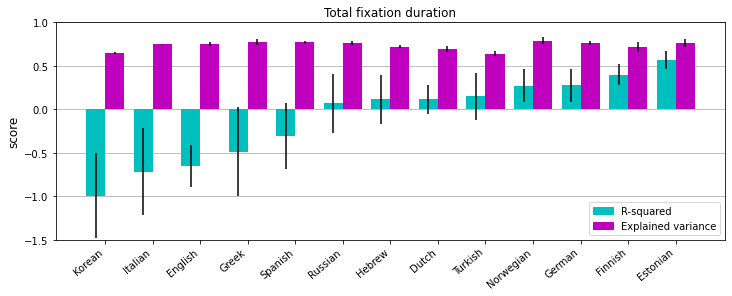

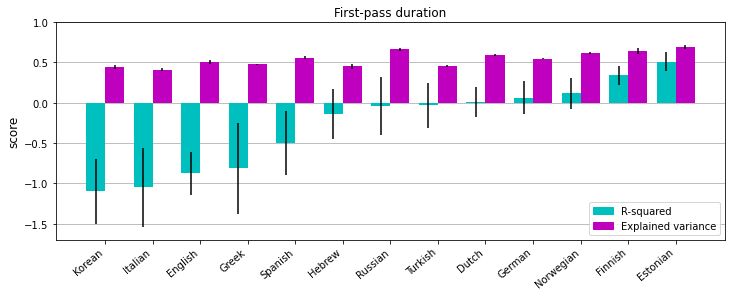

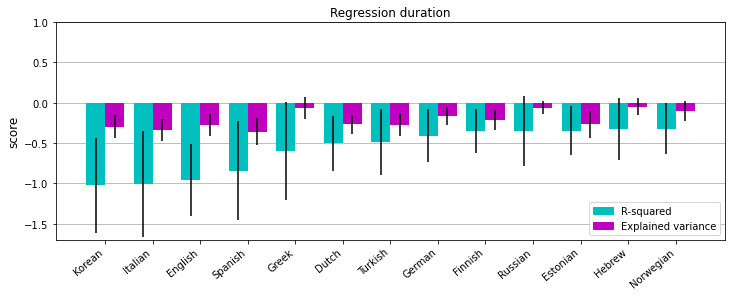

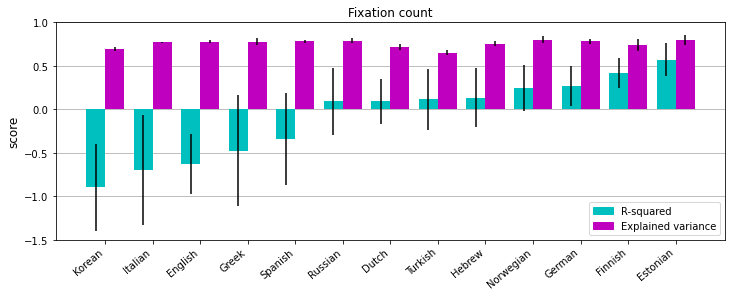

In [17]:
import matplotlib.patches as mpatches
import matplotlib as mpl

eval_df = make_eval_df(make_pred_df())
languages = ['Estonian', 'Italian', 'English', 'Dutch', 'Finnish', 'Hebrew', 'Russian', 'Turkish', 'Korean', 'German', 'Greek', 'Spanish', 'Norwegian']

title_dict = {'scaled_tot_fix_dur': 'Total fixation duration',
                 'scaled_first_pass_dur': 'First-pass duration',
                 'scaled_tot_regr_from_dur': 'Regression duration',
                  'scaled_fix_count': 'Fixation count'}

for et_metric in title_dict.keys():

    eval_df_target = eval_df.groupby('et_metric').get_group(et_metric).reset_index(drop=True)

    for input_type in ['normal']:

        all_data = []

        for language in languages:

            df_lang = eval_df_target.groupby('language').get_group(language).reset_index(drop=True)
            df_input_type = df_lang.groupby('input_type').get_group(input_type).reset_index(drop=True).describe()
            all_data.append([f'{language}', df_input_type['exp_var']['mean'], df_input_type['exp_var']['std'],
                                            df_input_type['r2']['mean'], df_input_type['r2']['std']])

        # order data by r2 score
        df_all_data = pd.DataFrame(all_data, columns=['language', 'exp_var', 'std_ev', 'r2', 'std_r2'])
        df_all_data_sorted = df_all_data.sort_values(by=['r2'], ascending=True).reset_index(drop=True)

        # plot grouped bar chart
        plt.figure(figsize=(12,4))
#         ax1 = plt.bar(x=df_all_data_sorted['language'],
#                       height=df_all_data_sorted['exp_var'],
#                       width=0.6,
#                       yerr = df_all_data_sorted['std_ev'].tolist(),
#                       color = get_color_scheme(df_all_data_sorted['r2'].tolist()),
#                       zorder=3)
        
        x = np.arange(13)
        y1 = df_all_data_sorted['r2']
        y2 = df_all_data_sorted['exp_var']
        width = 0.4
        plt.bar(x-0.2, y1, width, color='c', yerr=df_all_data_sorted['std_r2'], zorder=3)
        plt.bar(x+0.2, y2, width, color='m', yerr=df_all_data_sorted['std_ev'], zorder=3)
        
        # add title etc.
        if input_type == 'normal':
            title = f'{title_dict[et_metric]}'
        else:
            title = f'{title_dict[et_metric]} ({input_type} input)'
            
        if et_metric == 'scaled_tot_fix_dur' or et_metric =='scaled_fix_count':
            ylim = (-1.5, 1.0)
        else:
            ylim = (-1.7, 1.0)

        plt.title(title)
        plt.ylim(ylim)
        plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], labels=df_all_data_sorted['language'], rotation=40, horizontalalignment='right')
        plt.grid(axis='y', zorder=0)
        plt.ylabel(f'score', fontsize=12)
        c_patch = mpatches.Patch(color='c', label='R-squared')
        m_patch = mpatches.Patch(color='m', label='Explained variance')
        plt.legend(handles=[c_patch, m_patch], loc='lower right')

        plt.savefig(f'eval_{title_dict[et_metric].lower()}_{input_type}.pdf', dpi=300, bbox_inches='tight')

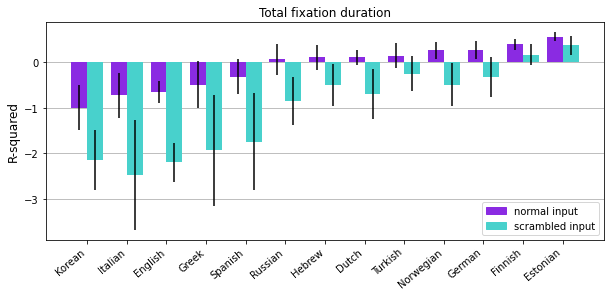

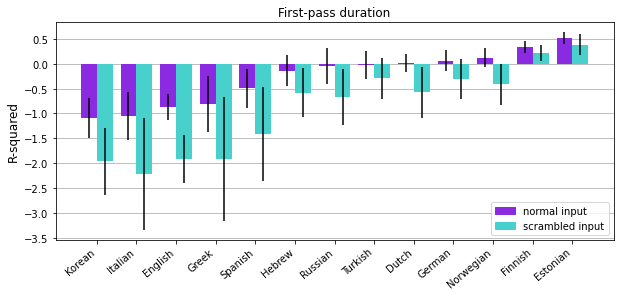

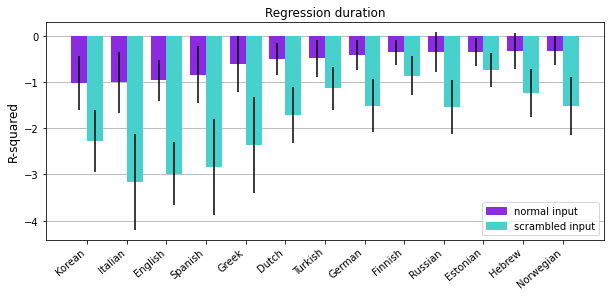

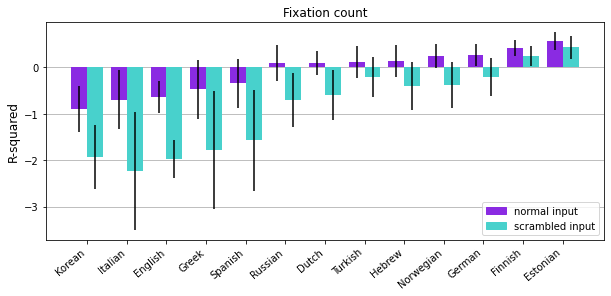

In [30]:
import matplotlib.patches as mpatches

eval_df = make_eval_df(make_pred_df())
languages = ['Estonian', 'Italian', 'English', 'Dutch', 'Finnish', 'Hebrew', 'Russian', 'Turkish', 'Korean', 'German', 'Greek', 'Spanish', 'Norwegian']

title_dict = {'scaled_tot_fix_dur': 'Total fixation duration',
                 'scaled_first_pass_dur': 'First-pass duration',
                 'scaled_tot_regr_from_dur': 'Regression duration',
                  'scaled_fix_count': 'Fixation count'}

for et_metric in title_dict.keys():

    eval_df_target = eval_df.groupby('et_metric').get_group(et_metric).reset_index(drop=True)

    all_data = []

    for language in languages:

        df_lang = eval_df_target.groupby('language').get_group(language).reset_index(drop=True)
        normal_scores = df_lang.groupby('input_type').get_group('normal').reset_index(drop=True).describe()
        scrambled_scores = df_lang.groupby('input_type').get_group('scrambled').reset_index(drop=True).describe()

        all_data.append([f'{language}', 
                                normal_scores['exp_var']['mean'], 
                                normal_scores['exp_var']['std'],
                                normal_scores['r2']['mean'],
                                normal_scores['r2']['std'],
                               scrambled_scores['exp_var']['mean'],
                               scrambled_scores['exp_var']['std'],
                               scrambled_scores['r2']['mean'],
                               scrambled_scores['r2']['std']])

    # order data by r2 score
    df_all_data = pd.DataFrame(all_data, columns=['language', 'exp_var_n', 'std_ev_n', 'r2_n', 'std_r2_n',
                                                 'exp_var_s', 'std_ev_s', 'r2_s', 'std_r2_s'])
    
    df_all_data_sorted = df_all_data.sort_values(by=['r2_n'], ascending=True).reset_index(drop=True)

    plt.figure(figsize=(10,4))
    x = np.arange(13)
    y1 = df_all_data_sorted['r2_n']
    y2 = df_all_data_sorted['r2_s']
    width = 0.4
    plt.bar(x-0.2, y1, width, color='blueviolet', yerr=df_all_data_sorted['std_r2_n'], zorder=3)
    plt.bar(x+0.2, y2, width, color='mediumturquoise', yerr=df_all_data_sorted['std_r2_s'], zorder=3)

    plt.title(title_dict[et_metric])
    plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12],labels=df_all_data_sorted['language'], rotation=40, horizontalalignment='right')
    plt.grid(axis='y', zorder=0)
    plt.ylabel(f'R-squared', fontsize=12)
    c_patch = mpatches.Patch(color='blueviolet', label='normal input')
    m_patch = mpatches.Patch(color='mediumturquoise', label='scrambled input')
    plt.legend(handles=[c_patch, m_patch], loc='lower right')

    plt.savefig(f'eval_{title_dict[et_metric].lower()}_scrambled-vs-normal.pdf', dpi=300, bbox_inches='tight')